In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as ns
%matplotlib inline
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [6]:
pd.set_option('display.max_columns', 60)
myData=pd.read_csv('imputedData.csv')
myData.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [7]:
#One hot encoding of categorical variables

#Create list with features to be dummified cols.
nonum_feats_names = ['Month','OperatingSystems','Browser','Region','VisitorType','Weekend']


dataModel = pd.concat([myData[['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 
                              'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues',
                               'TrafficType','SpecialDay']],
                       pd.get_dummies(myData[nonum_feats_names].astype('category')),myData['Revenue']],axis=1)
                      
dataModel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 57 columns):
Administrative                   12330 non-null int64
Administrative_Duration          12330 non-null float64
Informational                    12330 non-null int64
Informational_Duration           12330 non-null float64
ProductRelated                   12330 non-null int64
ProductRelated_Duration          12330 non-null float64
BounceRates                      12330 non-null float64
ExitRates                        12330 non-null float64
PageValues                       12330 non-null float64
TrafficType                      12330 non-null int64
SpecialDay                       12330 non-null float64
Month_Aug                        12330 non-null uint8
Month_Dec                        12330 non-null uint8
Month_Feb                        12330 non-null uint8
Month_Jul                        12330 non-null uint8
Month_June                       12330 non-null uint8
Month_Mar    

In [8]:
#Label Encoding of revenue

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
myData['Revenue'] = le.fit_transform(myData['Revenue'])
myData['Revenue'].value_counts()

myData['Revenue'].head()

# getting dependent and independent variables

x = dataModel
# removing the target column revenue from x
x = x.drop(['Revenue'], axis = 1)

y = myData['Revenue']

# checking the shapes
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

Shape of x: (12330, 56)
Shape of y: (12330,)


In [9]:
# splitting the data

from sklearn.model_selection import train_test_split

x_baseTrain, x_baseTest, y_baseTrain, y_baseTest = train_test_split(x, y, test_size = 0.3, random_state = 42)

# checking the shapes

print("Shape of x_train :", x_baseTrain.shape)
print("Shape of y_train :", y_baseTrain.shape)
print("Shape of x_test :", x_baseTest.shape)
print("Shape of y_test :", y_baseTest.shape)

Shape of x_train : (8631, 56)
Shape of y_train : (8631,)
Shape of x_test : (3699, 56)
Shape of y_test : (3699,)


In [10]:
#SCALING WITH STANDARD Z SCORE SCALER
#Scaling the data first fitting it and transforming the training set
#to later apply the fit to transform the test set.
from sklearn.preprocessing import StandardScaler

num_cols_names = ['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 
                              'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues',
                               'TrafficType','SpecialDay']

#Instantiate Satandard Scaler
scaler = StandardScaler()
#Fit transform the numerical features in the training dataset to a new dataframe
scaled_numfeats_train = pd.DataFrame(scaler.fit_transform(x_baseTrain[num_cols_names]), 
                                     columns=num_cols_names, index= x_baseTrain.index)
#Integrate scaled values to the training set
for col in num_cols_names:
    x_baseTrain[col] = scaled_numfeats_train[col]
    
    
#Transform the numerical features inthe training dataset to a new dataframe
scaled_numfeats_test = pd.DataFrame(scaler.transform(x_baseTest[num_cols_names]),
                                    columns=num_cols_names, index= x_baseTest.index)
#Integrate scaled values to the test set
for col in num_cols_names:
    x_baseTest[col] = scaled_numfeats_test[col]

C:\Users\neera\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\neera\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit. applying this feature selection on corr fixed data

In [11]:
x_baseTrain.drop(labels=['Browser_1','BounceRates','ProductRelated','VisitorType_Returning_Visitor'], 
                 axis=1, inplace=True)
x_baseTest.drop(labels=['Browser_1','BounceRates','ProductRelated','VisitorType_Returning_Visitor'], 
                axis=1, inplace=True)

x_baseTrain.shape, x_baseTest.shape

C:\Users\neera\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


((8631, 52), (3699, 52))

In [12]:
# the first step of this procedure  consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_all_features = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

model_all_features.fit(x_baseTrain, y_baseTrain)

# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict_proba(x_baseTest)[:, 1]
auc_score_all = roc_auc_score(y_baseTest, y_pred_test)
print('Test all features xgb ROC AUC=%f' % (auc_score_all))

Test all features xgb ROC AUC=0.925058


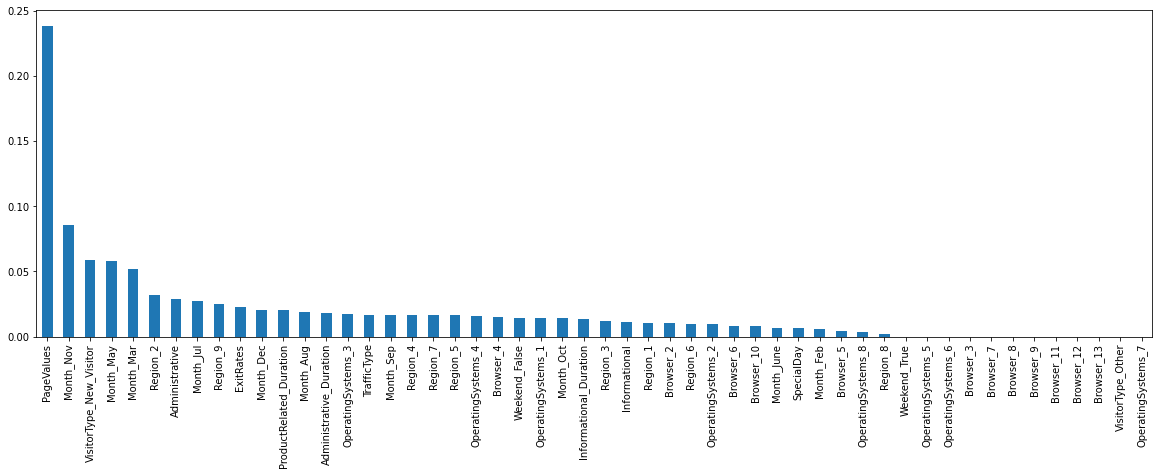

In [13]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the most to the least
# important

# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = x_baseTrain.columns

# sort the features by importance
features.sort_values(ascending=False, inplace=True)

# plot
features.plot.bar(figsize=(20,6))

In [14]:
# view the list of ordered features
features = list(features.index)
features

['PageValues',
 'Month_Nov',
 'VisitorType_New_Visitor',
 'Month_May',
 'Month_Mar',
 'Region_2',
 'Administrative',
 'Month_Jul',
 'Region_9',
 'ExitRates',
 'Month_Dec',
 'ProductRelated_Duration',
 'Month_Aug',
 'Administrative_Duration',
 'OperatingSystems_3',
 'TrafficType',
 'Month_Sep',
 'Region_4',
 'Region_7',
 'Region_5',
 'OperatingSystems_4',
 'Browser_4',
 'Weekend_False',
 'OperatingSystems_1',
 'Month_Oct',
 'Informational_Duration',
 'Region_3',
 'Informational',
 'Region_1',
 'Browser_2',
 'Region_6',
 'OperatingSystems_2',
 'Browser_6',
 'Browser_10',
 'Month_June',
 'SpecialDay',
 'Month_Feb',
 'Browser_5',
 'OperatingSystems_8',
 'Region_8',
 'Weekend_True',
 'OperatingSystems_5',
 'OperatingSystems_6',
 'Browser_3',
 'Browser_7',
 'Browser_8',
 'Browser_9',
 'Browser_11',
 'Browser_12',
 'Browser_13',
 'VisitorType_Other',
 'OperatingSystems_7']

In [15]:
# next, we need to build a machine learning
# algorithm using only the most important feature

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_one_feature = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

# train using only the most important feature
model_one_feature.fit(x_baseTrain[features[0]].to_frame(), y_baseTrain)

# calculate the roc-auc in the test set
y_pred_test = model_one_feature.predict_proba(x_baseTest[features[0]].to_frame())[:, 1]
auc_score_first = roc_auc_score(y_baseTest, y_pred_test)
print('Test one feature xgb ROC AUC=%f' % (auc_score_first))

Test one feature xgb ROC AUC=0.856753


In [16]:
# the final step consists in adding one at a time
# all the features, from the most to the least
# important, and build an xgboost at each round.

# once we build the model, we calculate the new roc-auc
# if the new roc-auc is bigger than the original one
# (with one feature), then that feature that was added
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature addition:

# first we arbitrarily set the increase in roc-auc
# if the increase is above this threshold,
# the feature will be kept
tol = 0.001

print('doing recursive feature addition')

# we initialise a list where we will collect the
# features we should keep
features_to_keep = [features[0]]

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features[1:]:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = xgb.XGBClassifier(
        nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(
        x_baseTrain[features_to_keep + [feature] ], y_baseTrain)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        x_baseTest[features_to_keep + [feature] ])[:, 1]

    # calculate the new roc-auc
    auc_score_int = roc_auc_score(y_baseTest, y_pred_test)
    print('New Test ROC AUC={}'.format((auc_score_int)))

    # print the original roc-auc with one feature
    print('All features Test ROC AUC={}'.format((auc_score_first)))

    # determine the increase in the roc-auc
    diff_auc = auc_score_int - auc_score_first

    # compare the increase in roc-auc with the tolerance
    # we set previously
    if diff_auc >= tol:
        print('Increase in ROC AUC={}'.format(diff_auc))
        print('keep: ', feature)
        print
        # if the increase in the roc is bigger than the threshold
        # we keep the feature and re-adjust the roc-auc to the new value
        # considering the added feature
        auc_score_first = auc_score_int
        
        # and we append the feature to keep to the list
        features_to_keep.append(feature)
    else:
        # we ignore the feature
        print('Increase in ROC AUC={}'.format(diff_auc))
        print('remove: ', feature)
        print


# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to keep: ', len(features_to_keep))

doing recursive feature addition

testing feature:  Month_Nov  which is feature  1  out of  52
New Test ROC AUC=0.9004459166063575
All features Test ROC AUC=0.85675304793186
Increase in ROC AUC=0.04369286867449751
keep:  Month_Nov

testing feature:  VisitorType_New_Visitor  which is feature  2  out of  52
New Test ROC AUC=0.9105191226409842
All features Test ROC AUC=0.9004459166063575
Increase in ROC AUC=0.010073206034626692
keep:  VisitorType_New_Visitor

testing feature:  Month_May  which is feature  3  out of  52
New Test ROC AUC=0.9174892835272505
All features Test ROC AUC=0.9105191226409842
Increase in ROC AUC=0.00697016088626623
keep:  Month_May

testing feature:  Month_Mar  which is feature  4  out of  52
New Test ROC AUC=0.9208815342648778
All features Test ROC AUC=0.9174892835272505
Increase in ROC AUC=0.003392250737627389
keep:  Month_Mar

testing feature:  Region_2  which is feature  5  out of  52
New Test ROC AUC=0.9201508656683182
All features Test ROC AUC=0.92088153426487

New Test ROC AUC=0.9306775037577242
All features Test ROC AUC=0.9306775037577242
Increase in ROC AUC=0.0
remove:  Weekend_True

testing feature:  OperatingSystems_5  which is feature  41  out of  52
New Test ROC AUC=0.9306775037577242
All features Test ROC AUC=0.9306775037577242
Increase in ROC AUC=0.0
remove:  OperatingSystems_5

testing feature:  OperatingSystems_6  which is feature  42  out of  52
New Test ROC AUC=0.9306775037577242
All features Test ROC AUC=0.9306775037577242
Increase in ROC AUC=0.0
remove:  OperatingSystems_6

testing feature:  Browser_3  which is feature  43  out of  52
New Test ROC AUC=0.9305344318877693
All features Test ROC AUC=0.9306775037577242
Increase in ROC AUC=-0.00014307186995488053
remove:  Browser_3

testing feature:  Browser_7  which is feature  44  out of  52
New Test ROC AUC=0.9308061014307187
All features Test ROC AUC=0.9306775037577242
Increase in ROC AUC=0.00012859767299455704
remove:  Browser_7

testing feature:  Browser_8  which is feature  45

In [17]:
# capture the 9 selected features
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model
final_xgb = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

# fit the model with the selected features
final_xgb.fit(x_baseTrain[features_to_keep], y_baseTrain)

# make predictions
y_pred_test = final_xgb.predict_proba(x_baseTest[features_to_keep])[:, 1]

# calculate roc-auc
auc_score_final = roc_auc_score(y_baseTest, y_pred_test)
print('Test selected features ROC AUC=%f' % (auc_score_final))

Test selected features ROC AUC=0.930678


Using a threshold / tolerance of 0.001 we selected 9 features. The model built with 9 features is far more predictive than the one built with 1 feature. In addition, the model built with 9 features is more predictive than the one built with all the features (0.93 vs 0.92). And if you remember from the previous lecture where we selected 14 features by recursive feature elimination, the roc-auc was 0.93, which indicates that many of those features are still redundant, as a model built with 9 features seems to perform better.

# Top features

In [20]:
features_to_keep

['PageValues',
 'Month_Nov',
 'VisitorType_New_Visitor',
 'Month_May',
 'Month_Mar',
 'Administrative',
 'ProductRelated_Duration',
 'Administrative_Duration',
 'Weekend_False']